# Reinforcement Learning for Wordle

## Problem Statement
Last week a working collegue showed me Wordle. Since he has been playing Wordle for a long period of time, I thought I could use this project to cheat my way through our games, so that I can beat him in future.

## So what is Wordle? 

Wordle is a word puzzle game where a player has six chances to guess a five-letter word. Only valid words are accepted. After each guess, the player receives feedback:
- **Green**: The letter is correct and in the right position.
- **Orange**: The letter is used in the target word but it is in the wrong position.
- **Gray**: The letter is not in the word at all.

While there are various strategies available online to optimize guessing, there is no definitive approach to consistently solving Wordle efficiently. Most people use words in the beginning that use the most common letters in order to find out
which letters are used in the target word.
Common starting words include:
- **SLATE**
- **CRANE**
- **TRACE**


However, the best strategy is to adapt based on the feedback received.


## Solution Implementation
My project aims to develop a **Reinforcement Learning (RL) model** to build an adaptive strategy for solving Wordle puzzles more efficiently and most importantly, faster than my collegue. The RL model will:
1. Learn through trial and error.
2. Optimize guesses based on past experiences.
3. Adjust its strategy dynamically based on the feedback received in each round.

## How does it work?

The implementation is based on **Deep Q-Learning (DQN)**, where:
- The **state** represents the current knowledge of the word (correct, misplaced, and incorrect letters). This is then stored in a 6,5 matrix that is updated after each guess.
- The **action** is choosing a word from a predefined vocabulary, filtered to remove unlikely options based on previous feedback.
- The **reward** is based on how close the guess is to the correct word—extra points for correct letters in the right spots and a penalty for unnecessary guesses. (Without this penalty guessing 5 times with 4 correct words would result in higher reward then guessing 2 times and then finding the correct word)

The code uses **PyTorch** for neural network training and **a custom Gym Enviroment** to simulate a Wordle game.

## How can you use it?
To run the model, you need to have the following files and dependencies in place:

### Required Files:
1. `wordle_env.py` - Implements the Wordle game environment in a format compatible with reinforcement learning.
2. `dqn_model.py` - Contains the DQN architecture for decision-making.
3. `train.py` - The main training script that runs episodes and updates the model.
4. `word_list.txt` - A list of possible words that can be used for training and evaluation.

### Installation:
Ensure you have the required dependencies installed:
```bash
pip install torch numpy gym
```

### Running the Model:
To train the reinforcement learning model, execute:
```bash
python train.py
```
This will run multiple training episodes, and thus refine the model´s guessing strategy, Once it is trained it is saved then as  `wordle_dqn_model_optimized.pth`.

## Conclusion
This project explored how reinforcement learning can be applied to solve Wordle in a smarter Way. By learning from experience and adjusting dynamically, the model aims to perform better than traditional word guessing strategies - and most importantly then me who is still trying to learn how to play this in the best way.


In [50]:
# First I looked online for a valid word list for Wordle. I then scraped the results and saved them in a file. My program should use words from this list as targets and use the list to filter the outcome.
import requests
url = "https://gist.githubusercontent.com/cfreshman/a03ef2cba789d8cf00c08f767e0fad7b/raw/45c977427419a1e0edee8fd395af1e0a4966273b/wordle-answers-alphabetical.txt"
response = requests.get(url)
response.raise_for_status()
word_list = [word.strip().lower() for word in response.text.split("\n") if len(word) == 5]

with open("wordle_words.txt", "w", encoding="utf-8") as file:
    file.write("\n".join(word_list))


This is the best Version I got until now. 

In [64]:
import requests
import random
import numpy as np
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import torch.nn.functional as F

# First change: I took out the Start Words as it made the program too efficient and therefore the program was not able to really get better
# First I define starting words that contain the most frequently used letters (according to the best Wordle startegy online)
#START_WORDS = ["slate", "crane", "trace"]

# Then I define the Wordle environment
class WordletwoEnv(gym.Env):
    def __init__(self, word_list):
        super(WordletwoEnv, self).__init__()
        self.word_list = word_list
        
        self.action_space = gym.spaces.Discrete(len(self.word_list))
        self.observation_space = gym.spaces.Box(low=0, high=2, shape=(6, 5), dtype=np.int8)
        self.history = np.zeros((6, 5), dtype=np.int8)
        
        self.green_letters = [''] * 5
        self.yellow_letters = {}
        self.gray_letters = set()
        
        self.reset()
    
    def reset(self):
        self.target_word = random.choice(self.word_list)
        self.attempts = 0
        self.done = False
        self.history.fill(0)
        self.green_letters = [''] * 5
        self.yellow_letters.clear()
        self.gray_letters.clear()
    
        return self.history

    def filter_valid_words(self):
        valid_words = []
        for word in self.word_list:
            valid = True

            # Check green letters
            for i, letter in enumerate(self.green_letters):
                if letter and word[i] != letter:
                    valid = False
                    break

            # Check gray letters
            if any(letter in word for letter in self.gray_letters):
                valid = False
            
            # Check yellow letters
            for letter, positions in self.yellow_letters.items():
                if letter not in word:
                    valid = False
                    break
                if any(word[pos] == letter for pos in positions):
                    valid = False
                    break

            if valid:
                valid_words.append(word)

        return valid_words if valid_words else self.word_list  # Fallback if no valid words left

    def best_guess(self, valid_words):
        return max(valid_words, key=lambda w: len(set(w) - self.gray_letters))
    
    def step(self, action):
        if self.done:
            return self.history, 0, self.done, {}

        valid_words = self.filter_valid_words()
        if len(valid_words) == 0:
            valid_words = self.word_list  # Fallback selection

        guess_word = self.best_guess(valid_words)

        feedback = self._get_feedback(guess_word)
        self.history[self.attempts] = feedback
        self.attempts += 1

        reward = self._calculate_reward(feedback, guess_word)

        if guess_word == self.target_word:
            reward += 100
            self.done = True

        if self.attempts >= 6:
            self.done = True

        return self.history, reward, self.done, {"word_guessed": guess_word == self.target_word, "attempts": self.attempts}
    

    # Change 2: I tried many rewards structures and found this to be the most effcient one. I give more rewards now for yelow and green letters and I am much harsher with grey letters.
    # Furthermore I added an exponentially scaling bonus for guessing the word correctly, meaning earlier correct guesses earn significantly more points.

    def _calculate_reward(self, feedback, guess_word):
        green_count = np.count_nonzero(feedback == 2)
        yellow_count = np.count_nonzero(feedback == 1)
        gray_count = 5 - (green_count + yellow_count)

        # Belohnungen für richtige Buchstaben
        reward = green_count * 25  # higher reward (before 15)
        reward += yellow_count * 10  #  slightly higher reward for right letter wrong place (before 7)
        
        # Higher penalty for wrong (grey) letters
        reward -= gray_count * 5  # Previously it was 2

        # Exponential reward for guessing the word ealier (less attempts)
        if guess_word == self.target_word:
            reward += int(1000 * (0.80 ** self.attempts))
            self.done = True

        # hgher penalty for needing too many attempts. Previously it was only 8 – now it is much more
        reward -= self.attempts * 20
        return reward
    

  #  def _calculate_reward(self, feedback, guess_word):
        green_count = np.count_nonzero(feedback == 2)
        yellow_count = np.count_nonzero(feedback == 1)

        
        reward = green_count * 15  
        reward += yellow_count * 7  
        
        
        gray_count = 5 - (green_count + yellow_count)
        reward -= gray_count * 2  

        
        if guess_word == self.target_word:
            reward += int(500 * (0.85 ** self.attempts))  
            self.done = True

      
        reward -= self.attempts * 20

        return reward


    #def _calculate_reward(self, feedback, guess_word):
        reward = np.count_nonzero(feedback == 2) * 10  # Higher reward for correct letters (in Wordle green)
        reward += np.count_nonzero(feedback == 1) * 5  # Moderate reward for correct letters in wrong position (in Wordle yellow)
        reward -= 1  # Small penalty for each guess to encourage efficiency (in previous models the reward system did not work because guessing the word correctly after 2 times did get less rewards then guessing 5 times 4 correct letters and then finding the correct word)
        return reward
   ## This reward stucture gave me worse results
   # def _calculate_reward(self, feedback, guess_word):
        reward = np.count_nonzero(feedback == 2) * 10  # 10 points per correct letter (green)
        reward += np.count_nonzero(feedback == 1) * 5  # 5 points per misplaced letter (yellow)
        
        # BIG Reward for finding the correct word, decreasing with attempts
        if guess_word == self.target_word:
            reward += 500 - (self.attempts * 20)  # Large base reward, decreasing per attempt
            self.done = True

        # Penalty per guess to encourage efficiency
        reward -= self.attempts * 5  # Increasing penalty the more attempts are used
    
        return reward


    def _get_feedback(self, guess):
        feedback = np.zeros(5, dtype=np.int8)
        target_word_list = list(self.target_word)
        
        for i, letter in enumerate(guess):
            if letter == self.target_word[i]:
                feedback[i] = 2
                self.green_letters[i] = letter
                target_word_list[i] = None
        
        for i, letter in enumerate(guess):
            if feedback[i] == 0 and letter in target_word_list:
                feedback[i] = 1
                if letter not in self.yellow_letters:
                    self.yellow_letters[letter] = set()
                self.yellow_letters[letter].add(i)
                target_word_list[target_word_list.index(letter)] = None
            elif feedback[i] == 0:
                self.gray_letters.add(letter)
        
        return feedback
    def test_step(self, action):
        """ Step function for testing. Prints attempts for understanding. """
        if self.done:
            return self.history, 0, self.done, {}

        valid_words = self.filter_valid_words()
        if len(valid_words) == 0:
            print("No valid words left! Using fallback selection.")
            valid_words = self.word_list

        # Select the best guess
        guess_word = self.best_guess(valid_words)

        feedback = self._get_feedback(guess_word)

        # Print output to understanding how it works and thus debugging
        print(f"Attempt {self.attempts + 1}: {guess_word.upper()}")
        print("Feedback:", " ".join(["🟩" if x == 2 else "🟨" if x == 1 else "⬜" for x in feedback]))

        self.history[self.attempts] = feedback
        self.attempts += 1

        reward = np.count_nonzero(feedback == 2) * 5
        reward += np.count_nonzero(feedback == 1) * 2

        if guess_word == self.target_word:
            print(f"Correct word found in {self.attempts} attempts! 🎉")
            reward += 100
            self.done = True

        if self.attempts >= 6:
            print("Maximum attempts reached. Moving to next episode.")
            self.done = True

        return self.history, reward, self.done, {"word_guessed": guess_word == self.target_word, "attempts": self.attempts}

# Now I define the neural network
class WordleDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(WordleDQN, self).__init__()
        self.fc1 = nn.Linear(input_shape, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, num_actions)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

import pandas as pd
def train(env, model, optimizer, episodes=1000, gamma=0.99, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.999):  
    """ Increased epsilon decay rate to slow down initial learning. """
    memory = deque(maxlen=10000)
    batch_size = 64
    rewards_list = []
    epsilon_list = []
    episode_list = []
    attempts_list = []  # Stores attempts per episode
    success_list = [] # Stores whether the episode was successful (Step was needed because previously I could not understand the reward structure, as in a previous program there was a bug, no episode was successfull but all had high rewards)

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                state_tensor = torch.FloatTensor(state).unsqueeze(0)
                q_values = model(state_tensor)
                action = torch.argmax(q_values).item()

            next_state, reward, done, info = env.step(action)
            memory.append((state, action, reward, next_state, done))
            state = next_state
            total_reward += reward

            if len(memory) > batch_size:
                minibatch = random.sample(memory, batch_size)
                states, actions, rewards, next_states, dones = zip(*minibatch)

                states = torch.FloatTensor(np.array(states))
                actions = torch.LongTensor(actions)
                rewards = torch.FloatTensor(rewards)
                next_states = torch.FloatTensor(np.array(next_states))
                dones = torch.FloatTensor(dones)

                current_q = model(states).gather(1, actions.unsqueeze(1))
                next_q = model(next_states).max(1)[0].detach()
                target_q = rewards + (gamma * next_q * (1 - dones))

                loss = F.mse_loss(current_q.squeeze(), target_q)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        epsilon = max(epsilon_min, epsilon * epsilon_decay)  # Slower Decay 
        # Store episode data
        rewards_list.append(total_reward)
        epsilon_list.append(epsilon)
        episode_list.append(episode + 1)
        attempts_list.append(env.attempts)  # Track number of attempts
        success_list.append(int(info["word_guessed"]))  # 1 if successful, 0 otherwise

        print(f"Episode {episode + 1}, Total Reward: {total_reward}, Attempts: {env.attempts}, Success: {info['word_guessed']}, Epsilon: {epsilon:.5f}")

    results_df = pd.DataFrame({
        "Episode": episode_list,
        "Total Reward": rewards_list,
        "Attempts": attempts_list,
        "Success": success_list,
        "Epsilon": epsilon_list
    })
    results_df.to_csv("wordletwo_rl_results.csv", index=False)

    return rewards_list

# def train(env, model, optimizer, episodes=10000, gamma=0.99, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
    memory = deque(maxlen=10000)
    batch_size = 64
    rewards_list = []  
    epsilon_list = []  
    episode_list = []  
    attempts_list = []  # Stores attempts per episode
    success_list = []   # Stores whether the episode was successful (Step was needed because previously I could not understand the reward structure, as in a previous program there was a bug, no episode was successfull but all had high rewards)

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                state_tensor = torch.FloatTensor(state).unsqueeze(0)
                q_values = model(state_tensor)
                action = torch.argmax(q_values).item()

            next_state, reward, done, info = env.step(action)
            memory.append((state, action, reward, next_state, done))
            state = next_state
            total_reward += reward

            if len(memory) > batch_size:
                minibatch = random.sample(memory, batch_size)
                states, actions, rewards, next_states, dones = zip(*minibatch)

                states = torch.FloatTensor(np.array(states))
                actions = torch.LongTensor(actions)
                rewards = torch.FloatTensor(rewards)
                next_states = torch.FloatTensor(np.array(next_states))
                dones = torch.FloatTensor(dones)

                current_q = model(states).gather(1, actions.unsqueeze(1))
                next_q = model(next_states).max(1)[0].detach()
                target_q = rewards + (gamma * next_q * (1 - dones))

                loss = F.mse_loss(current_q.squeeze(), target_q)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        epsilon = max(epsilon_min, epsilon * epsilon_decay)

        # Store episode data
        rewards_list.append(total_reward)
        epsilon_list.append(epsilon)
        episode_list.append(episode + 1)
        attempts_list.append(env.attempts)  # Track number of attempts
        success_list.append(int(info["word_guessed"]))  # 1 if successful, 0 otherwise

        print(f"Episode {episode + 1}, Total Reward: {total_reward}, Attempts: {env.attempts}, Success: {info['word_guessed']}, Epsilon: {epsilon:.5f}")

    # Then I save results to a CSV file in order to be able to analyse them later 
    results_df = pd.DataFrame({
        "Episode": episode_list,
        "Total Reward": rewards_list,
        "Attempts": attempts_list,
        "Success": success_list,
        "Epsilon": epsilon_list
    })
    results_df.to_csv("wordletwo_rl_results.csv", index=False)

    return rewards_list

# Initialize environment and model
env = WordletwoEnv(word_list)
model = WordleDQN(env.observation_space.shape[0] * env.observation_space.shape[1], env.action_space.n)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
rewards = train(env, model, optimizer)

Episode 1, Total Reward: 717, Attempts: 3, Success: True, Epsilon: 0.99900
Episode 2, Total Reward: 494, Attempts: 4, Success: True, Epsilon: 0.99800
Episode 3, Total Reward: 464, Attempts: 4, Success: True, Epsilon: 0.99700
Episode 4, Total Reward: 347, Attempts: 5, Success: True, Epsilon: 0.99601
Episode 5, Total Reward: 642, Attempts: 3, Success: True, Epsilon: 0.99501
Episode 6, Total Reward: 642, Attempts: 3, Success: True, Epsilon: 0.99401
Episode 7, Total Reward: 479, Attempts: 4, Success: True, Epsilon: 0.99302
Episode 8, Total Reward: 554, Attempts: 4, Success: True, Epsilon: 0.99203
Episode 9, Total Reward: 509, Attempts: 4, Success: True, Epsilon: 0.99104
Episode 10, Total Reward: 377, Attempts: 5, Success: True, Epsilon: 0.99004
Episode 11, Total Reward: 717, Attempts: 3, Success: True, Epsilon: 0.98905
Episode 12, Total Reward: 464, Attempts: 4, Success: True, Epsilon: 0.98807
Episode 13, Total Reward: 287, Attempts: 5, Success: True, Epsilon: 0.98708
Episode 14, Total Rew

In [69]:
# I used this to run tests, to determine what I can change for it to run better. And to understand how the rewards are calculated. This helped me improve the model a lot.
num_tests = 10

for test in range(num_tests):
    env = WordletwoEnv(word_list)
    state = env.reset()
    total_reward = 0  # Track total reward per episode
    print(f"\nTest Episode {test + 1}: Target word is '{env.target_word.upper()}' (Hidden from RL)")

    done = False
    attempt = 1  # Track attempt number

    while not done:
        action = random.randint(0, len(env.word_list) - 1)
        state, reward, done, info = env.test_step(action)
        total_reward += reward  # Accumulate total reward

        # Print reward for this attempt
        print(f"Attempt {attempt}: Reward = {reward}, Total Reward = {total_reward}")
        attempt += 1

    print(f"Test Episode {test + 1} completed. Total Reward: {total_reward}\n")



Test Episode 1: Target word is 'SHALE' (Hidden from RL)
Attempt 1: ABHOR
Feedback: 🟨 ⬜ 🟨 ⬜ ⬜
Attempt 1: Reward = 4, Total Reward = 4
Attempt 2: CHAFE
Feedback: ⬜ 🟩 🟩 ⬜ 🟩
Attempt 2: Reward = 15, Total Reward = 19
Attempt 3: PHASE
Feedback: ⬜ 🟩 🟩 🟨 🟩
Attempt 3: Reward = 17, Total Reward = 36
Attempt 4: SHADE
Feedback: 🟩 🟩 🟩 ⬜ 🟩
Attempt 4: Reward = 20, Total Reward = 56
Attempt 5: SHAKE
Feedback: 🟩 🟩 🟩 ⬜ 🟩
Attempt 5: Reward = 20, Total Reward = 76
Attempt 6: SHALE
Feedback: 🟩 🟩 🟩 🟩 🟩
Correct word found in 6 attempts! 🎉
Maximum attempts reached. Moving to next episode.
Attempt 6: Reward = 125, Total Reward = 201
Test Episode 1 completed. Total Reward: 201


Test Episode 2: Target word is 'LUCKY' (Hidden from RL)
Attempt 1: ABHOR
Feedback: ⬜ ⬜ ⬜ ⬜ ⬜
Attempt 1: Reward = 0, Total Reward = 0
Attempt 2: CLEFT
Feedback: 🟨 🟨 ⬜ ⬜ ⬜
Attempt 2: Reward = 4, Total Reward = 4
Attempt 3: LUCID
Feedback: 🟩 🟩 🟩 ⬜ ⬜
Attempt 3: Reward = 15, Total Reward = 19
Attempt 4: LUCKY
Feedback: 🟩 🟩 🟩 🟩 🟩
Correct wor

In [68]:
#Here I tried to find the worst games (least rewards) so I can try to improve them, but it did not really work. 
import random

num_tests = 20  # Increase test episodes to 20
reward_threshold = 100  # Maximum allowed reward per episode
max_attempts = 6  # Ensure all 6 attempts are visible per episode

for test in range(num_tests):
    env = WordletwoEnv(word_list)
    state = env.reset()
    total_reward = 0  # Track total reward per episode
    print(f"\nTest Episode {test + 1}: Target word is '{env.target_word.upper()}' (Hidden from RL)")
    
    done = False
    attempt = 1  # Track attempt number
    
    while not done and attempt <= max_attempts:
        action = random.randint(0, len(env.word_list) - 1)
        state, reward, done, info = env.test_step(action)
        total_reward += reward  # Accumulate total reward
        
        # Print reward for this attempt
        print(f"Attempt {attempt}: Reward = {reward}, Total Reward = {total_reward}")
        attempt += 1
        
    # Ensure total reward stays below the threshold and all 6 attempts are shown
    if total_reward <= reward_threshold:
        print(f"Total reward exceeded {reward_threshold}. Restarting episode...\n")
        total_reward = 0
        state = env.reset()
        attempt = 1
        continue
    
    print(f"Test Episode {test + 1} completed. Total Reward: {total_reward}\n")



Test Episode 1: Target word is 'ATOLL' (Hidden from RL)
Attempt 1: ABHOR
Feedback: 🟩 ⬜ ⬜ 🟨 ⬜
Attempt 1: Reward = 7, Total Reward = 7
Attempt 2: ADOPT
Feedback: 🟩 ⬜ 🟩 ⬜ 🟨
Attempt 2: Reward = 12, Total Reward = 19
Attempt 3: ATONE
Feedback: 🟩 🟩 🟩 ⬜ ⬜
Attempt 3: Reward = 15, Total Reward = 34
Attempt 4: ATOLL
Feedback: 🟩 🟩 🟩 🟩 🟩
Correct word found in 4 attempts! 🎉
Attempt 4: Reward = 125, Total Reward = 159
Test Episode 1 completed. Total Reward: 159


Test Episode 2: Target word is 'SPEND' (Hidden from RL)
Attempt 1: ABHOR
Feedback: ⬜ ⬜ ⬜ ⬜ ⬜
Attempt 1: Reward = 0, Total Reward = 0
Attempt 2: CLEFT
Feedback: ⬜ ⬜ 🟩 ⬜ ⬜
Attempt 2: Reward = 5, Total Reward = 5
Attempt 3: SPEND
Feedback: 🟩 🟩 🟩 🟩 🟩
Correct word found in 3 attempts! 🎉
Attempt 3: Reward = 125, Total Reward = 130
Test Episode 2 completed. Total Reward: 130


Test Episode 3: Target word is 'SYRUP' (Hidden from RL)
Attempt 1: ABHOR
Feedback: ⬜ ⬜ ⬜ ⬜ 🟨
Attempt 1: Reward = 2, Total Reward = 2
Attempt 2: CLERK
Feedback: ⬜ ⬜ ⬜ 🟨 ⬜
At

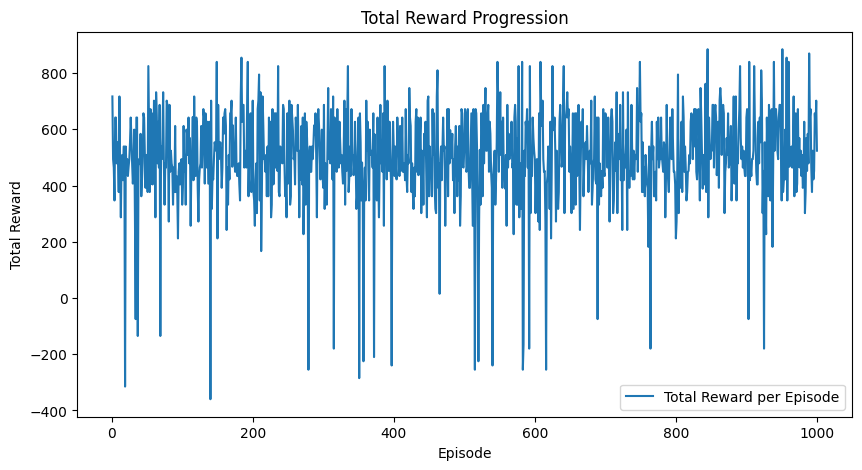

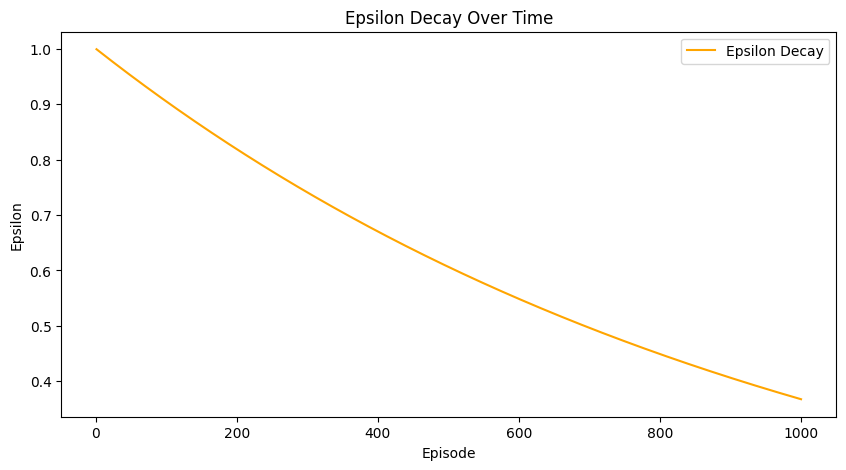

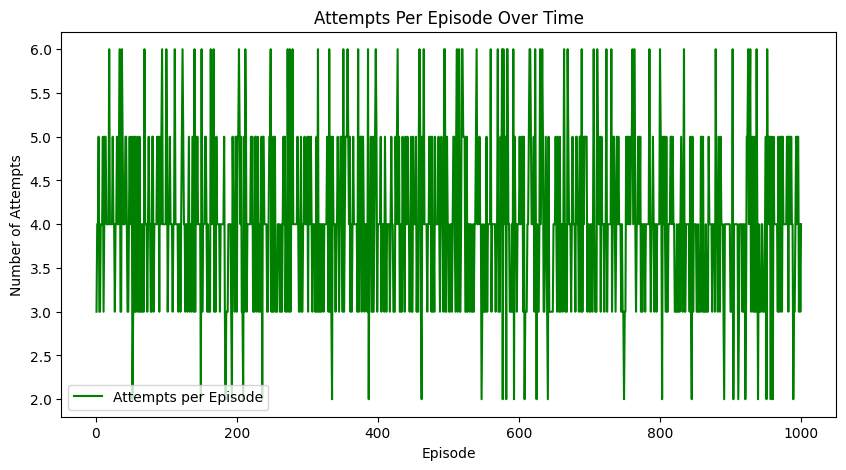

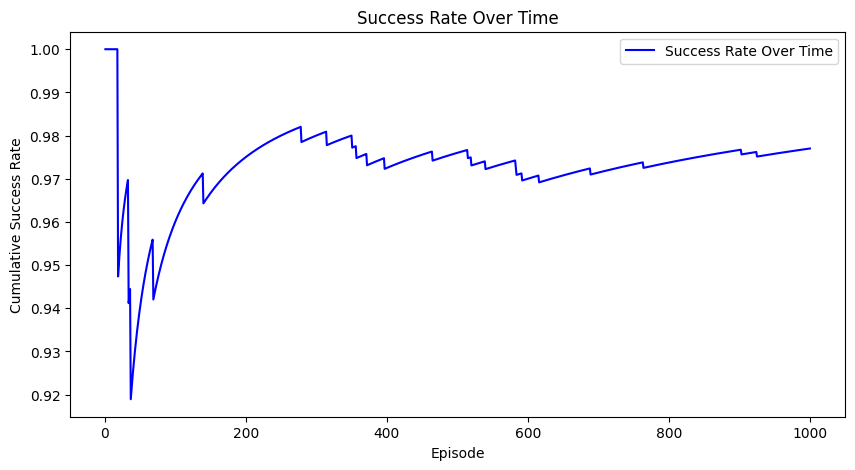

In [67]:
import matplotlib.pyplot as plt
import pandas as pd
# Load saved results
df_results = pd.read_csv("wordletwo_rl_results.csv")

# First I plot the total reward per episode
plt.figure(figsize=(10, 5))
plt.plot(df_results["Episode"], df_results["Total Reward"], label="Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward Progression")
plt.legend()
plt.show()

# Second I plot epsilon decay
plt.figure(figsize=(10, 5))
plt.plot(df_results["Episode"], df_results["Epsilon"], label="Epsilon Decay", color="orange")
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon Decay Over Time")
plt.legend()
plt.show()

# Then third I plot number of attempts per episode
plt.figure(figsize=(10, 5))
plt.plot(df_results["Episode"], df_results["Attempts"], label="Attempts per Episode", color="green")
plt.xlabel("Episode")
plt.ylabel("Number of Attempts")
plt.title("Attempts Per Episode Over Time")
plt.legend()
plt.show()

# Last I plot success rate over episodes
plt.figure(figsize=(10, 5))
plt.plot(df_results["Episode"], df_results["Success"].cumsum() / (df_results["Episode"]), label="Success Rate Over Time", color="blue")
plt.xlabel("Episode")
plt.ylabel("Cumulative Success Rate")
plt.title("Success Rate Over Time")
plt.legend()
plt.show()



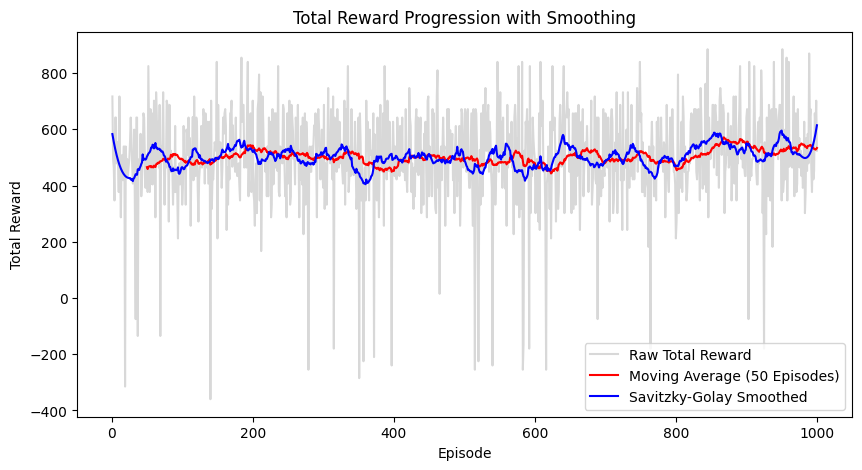

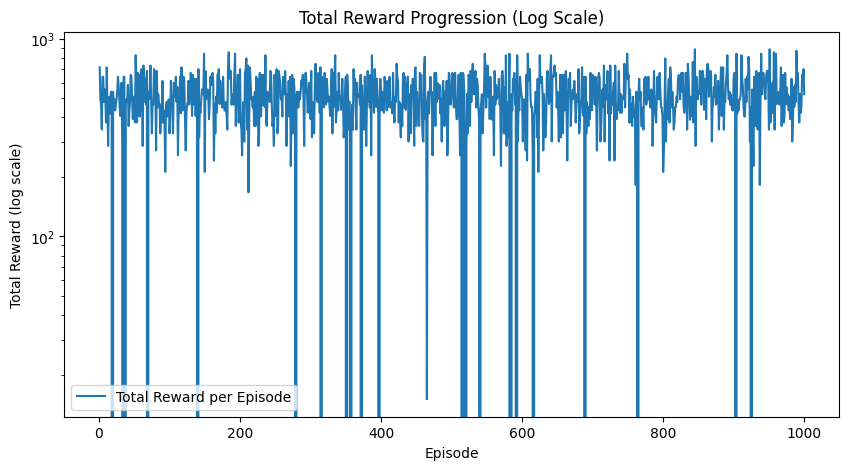

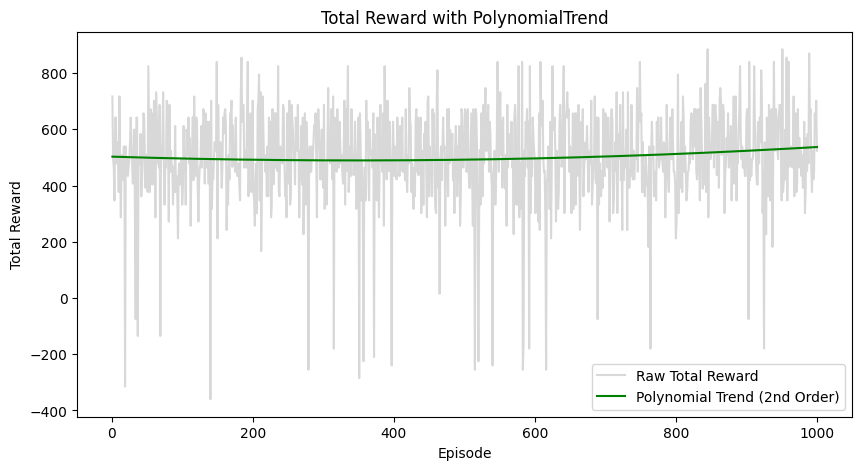

In [66]:
#Since the results are not amazing and the rewards remain almost the same I tried different plots

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

# Load saved results
df_results = pd.read_csv("wordletwo_rl_results.csv")

# Define a smoothing function (Moving Average)
def moving_average(data, window_size=50):
    return data.rolling(window=window_size).mean()

# Apply moving average to total rewards
df_results["Smoothed Reward"] = moving_average(df_results["Total Reward"], window_size=50)

# Apply Savitzky-Golay filter for better smoothing
df_results["Smoothed Reward SG"] = savgol_filter(df_results["Total Reward"], window_length=51, polyorder=3)

# Plot total reward per episode with different smoothing techniques
plt.figure(figsize=(10, 5))
plt.plot(df_results["Episode"], df_results["Total Reward"], label="Raw Total Reward", alpha=0.3, color="gray")
plt.plot(df_results["Episode"], df_results["Smoothed Reward"], label="Moving Average (50 Episodes)", color="red")
plt.plot(df_results["Episode"], df_results["Smoothed Reward SG"], label="Savitzky-Golay Smoothed", color="blue")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward Progression with Smoothing")
plt.legend()
plt.show()

# Plot total reward with log scale
plt.figure(figsize=(10, 5))
plt.plot(df_results["Episode"], df_results["Total Reward"], label="Total Reward per Episode")
plt.yscale("log")
plt.xlabel("Episode")
plt.ylabel("Total Reward (log scale)")
plt.title("Total Reward Progression (Log Scale)")
plt.legend()
plt.show()

# Polynomial trend line (2nd order)
coeffs = np.polyfit(df_results["Episode"], df_results["Total Reward"], 2)
poly_trend = np.polyval(coeffs, df_results["Episode"])

plt.figure(figsize=(10, 5))
plt.plot(df_results["Episode"], df_results["Total Reward"], label="Raw Total Reward", alpha=0.3, color="gray")
plt.plot(df_results["Episode"], poly_trend, label="Polynomial Trend (2nd Order)", color="green")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Reward with PolynomialTrend")
plt.legend()
plt.show()


Average reward in the first 100 episodes: 479.04
Average reward in the last 100 episodes: 527.91
Reward improvement: 48.87
Average attempts in the first 100 episodes: 4.10
Average attempts in the last 100 episodes: 3.89
Attempt improvement (lower is better): 0.21


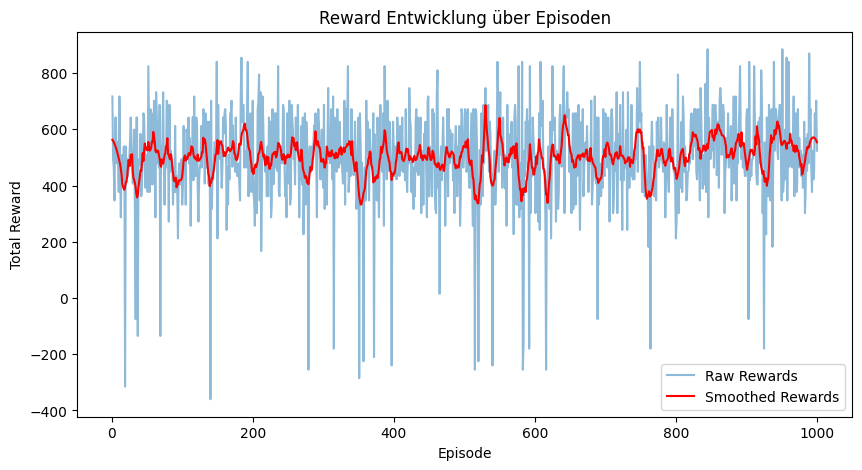

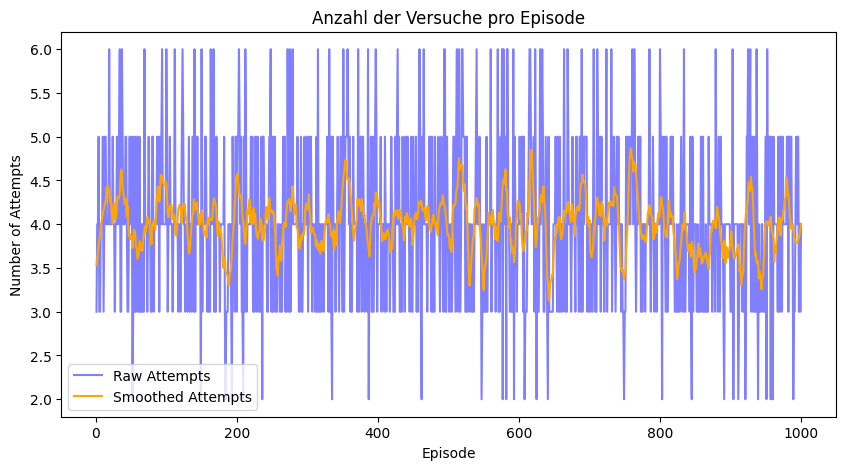

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

# Load saved results
df_results = pd.read_csv("wordletwo_rl_results.csv")

# Check if "Total Reward" and "Attempts" columns exist
if "Total Reward" not in df_results.columns or "Attempts" not in df_results.columns:
    print("Error: Necessary columns ('Total Reward' or 'Attempts') not found in CSV file.")
else:
    # Berechne die durchschnittliche Belohnung in den ersten und letzten 100 Episoden
    first_100_avg_reward = df_results["Total Reward"][:100].mean()
    last_100_avg_reward = df_results["Total Reward"][-100:].mean()

    # Berechne die durchschnittliche Anzahl an Versuchen (Attempts) in den ersten und letzten 100 Episoden
    first_100_avg_attempts = df_results["Attempts"][:100].mean()
    last_100_avg_attempts = df_results["Attempts"][-100:].mean()

    # Berechnung der Verbesserungen
    reward_improvement = last_100_avg_reward - first_100_avg_reward
    attempt_improvement = first_100_avg_attempts - last_100_avg_attempts  # Reduzierung = Verbesserung

    print(f"Average reward in the first 100 episodes: {first_100_avg_reward:.2f}")
    print(f"Average reward in the last 100 episodes: {last_100_avg_reward:.2f}")
    print(f"Reward improvement: {reward_improvement:.2f}")

    print(f"Average attempts in the first 100 episodes: {first_100_avg_attempts:.2f}")
    print(f"Average attempts in the last 100 episodes: {last_100_avg_attempts:.2f}")
    print(f"Attempt improvement (lower is better): {attempt_improvement:.2f}")

    # Plot der Reward-Entwicklung
    plt.figure(figsize=(10, 5))
    plt.plot(df_results["Episode"], df_results["Total Reward"], alpha=0.5, label="Raw Rewards")

    # Verwenden eines Savitzky-Golay-Filters zur Glättung der Rewards
    if len(df_results) > 20:
        smoothed_rewards = savgol_filter(df_results["Total Reward"], window_length=21, polyorder=2)
        plt.plot(df_results["Episode"], smoothed_rewards, color='red', label="Smoothed Rewards")

    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Reward Entwicklung über Episoden")
    plt.legend()
    plt.show()

    # Plot der Anzahl der Versuche pro Episode
    plt.figure(figsize=(10, 5))
    plt.plot(df_results["Episode"], df_results["Attempts"], alpha=0.5, label="Raw Attempts", color='blue')

    if len(df_results) > 20:
        smoothed_attempts = savgol_filter(df_results["Attempts"], window_length=21, polyorder=2)
        plt.plot(df_results["Episode"], smoothed_attempts, color='orange', label="Smoothed Attempts")

    plt.xlabel("Episode")
    plt.ylabel("Number of Attempts")
    plt.title("Anzahl der Versuche pro Episode")
    plt.legend()
    plt.show()
